### Q1: Let's start having some *real* fun...

We previously considered the normal-gamma specification 

$$\scriptsize
\begin{align*}
p(\theta,\tau|x) &\propto{} p(\theta,\tau,x) = p(x|\theta)p(\theta)p(\tau) \quad (\theta \perp\!\!\perp \tau) \leftarrow \text{independent priors} & p(\theta|x,\theta_0,\tau_0, \tau) &={} \text{N}\left(\frac{\left(\tau_0 \theta_0+\tau\sum_{i=1}^{n}x_{i}\right)}{(\tau_0+n\tau)}, \sigma^{-2}=\tau_0+n\tau \right)\\
&={}  \left[\prod_{i=1}^n\sqrt{\frac{\tau}{2\pi}} e^{-\frac{\tau\left(x_i-\theta\right)^2}{2}}\right] \sqrt{\frac{\tau_0}{2\pi}} e^{-\frac{\tau_0\left(\theta-\theta_0\right)^2}{2}} \frac{\beta ^{\alpha}}{\Gamma(\alpha)} \tau^{\alpha -1}e^{-\beta \tau} & p(\tau|x, \alpha, \beta, \theta) &={} \text{Gamma}\left(\frac{\alpha}{2}+\frac{n}{2}, \frac{\beta}{2}+\frac{1}{2}\sum_{i=1}^n\left(x_i-\theta\right)^2 \right)\\{}\\
\end{align*}$$

How about instead we consider a "[location-scale-t](https://en.wikipedia.org/wiki/Student%27s_t-distribution#Location-scale_t-distribution)-norm-halfnorm-discrete-uniform" specification?

$$\large
\overset{x_i\; \sim\; \text{location-scale-t}(\mu, \sigma^2, \nu)}{\quad\quad\quad p(x|\mu,\sigma^2, \nu)} = {\prod_{i=1}^n
\frac{\Gamma\left(\frac{\nu+1}{2}\right)}{\Gamma\left(\frac{\nu}{2}\right) \sqrt{\pi \nu \sigma^2}}\left(1+\frac{1}{\nu} \frac{(x_i-\mu)^2}{\sigma^2}\right)^{-(\nu+1) / 2}}$$

$$\scriptsize 
\begin{align}
p(\mu | \mu_0, \tau_0) &={} \sqrt{\frac{\tau_0}{2\pi}} e^{-\frac{\tau_0}{2}\left(\mu-\mu_0\right)^2} & p(\sigma^2 | \sigma_0^2) &={} \sqrt{\frac{2}{\pi\sigma_0^2}} \exp \left(-\frac{(\sigma^2)^2}{2 \sigma_0^2}\right) 1_{[0,\infty]}(\sigma^2) & p(\nu=i) &={} \Bigg\{ \begin{array}{cl} \frac{1}{100} & \text{for }i=1,\cdots,100\\ 0 & \text{otherwise} \end{array}\\
& \textrm{normal} && \textrm{half-normal} && \textrm{discrete uniform}
\end{align}
$$

Um yeah we're gonna need a Metroposlis cleanup on aisles one two and three  
(or a slice or adapative squeeze rejection sampling steps... in place of Metroposlis steps)

*Implement the a Metroposlis within Gibbs algorithm to smaple from the posterior of the above specification. Use a "smallish" sample size, say $n=100$ and implement your acceptance probability on a log-scale as described in [piazza post @65_f1](https://piazza.com/class/m5jvyco84083fm/post/65_f1)*

### Q1 Answer

Since the $x_i$ has the location-scale-t-norm-halfnorm-dicrete-uniform specification, we can use *stats.t* command to specify the likelihood function as a pdf of student-t distribution. Also, since there are 3 variables ($\mu$, $\nu$ and $\sigma^2$) and their priors are presented, I used these priors for the proposal distributions for each variable. Also, for $\nu$, I used symmetric random walk (uniform distribution) for generating random values for $\nu$. The conditions(null values) for each priors are assigned before the Metroposlis algorithm is applied.

*Note: for acceptance ratio, $\mu$ and $\nu$ cancels out the correction factors(ratios of proposal distribution) since their proposals are symmetric, but $\sigma^2$ do not cancel out the correction factor since Half-Normal distribution is not symmetric


In [7]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

# Data
n = 100  # Sample size

#---Assume true parameters----#
v_true=10
m_true=50
sigma_true=2
sigma2_true=4

# Hyperparmeters for priors of mu 
mu_0=55
tau_0=1.0

# Hyperparameters for priors of sigma^2
sigma2_0 = 6

x = stats.t.rvs(df=v_true, loc=m_true, scale=sigma_true, size=n)   # Simulated t-distributed data

def log_joint(mu, sigma2, nu, x, mu_0, tau_0, sigma2_0):
    """
    Unnormalized log joint density for (mu, sigma2, nu) given data x.
    - Likelihood: Student's t-distribution (location-scale)
    - Prior for mu: Normal(mu0, 1/tau0)
    - Prior for sigma2: Half-Normal(sigma0^2)
    - Prior for nu: Discrete Uniform(1,100)
    """
    n = len(x)
    
    # Log-Likelihood (Student's t-distribution)
    log_lik = np.sum(stats.t.logpdf(x, df=nu, loc=mu, scale=np.sqrt(sigma2)))
    
    # Log-Prior for mu (Normal prior)
    log_prior_mu = stats.norm.logpdf(mu, loc=mu_0, scale=1/np.sqrt(tau_0))
    
    # Log-Prior for sigma2 (Half-Normal prior)
    log_prior_sigma2 = stats.halfnorm.logpdf(sigma2, scale=np.sqrt(sigma2_0))
    
    # Log-Prior for nu (Discrete Uniform prior over {1, 2, ..., 100})
    log_prior_nu = -np.log(100) if (1 <= nu <= 100) else -np.inf
    
    return log_lik + log_prior_mu + log_prior_sigma2 + log_prior_nu

# Gibbs sampling parameters
C, G = 1, 10000  # 1 chain and 10000 iterations

In [3]:
# Storage for samples
mu_chain = np.zeros((C, G))
sigma2_chain = np.zeros((C, G))
nu_chain = np.zeros((C, G), dtype=int)

# Initialize values (can be any number)
mu_chain[:, 0] = 70
sigma2_chain[:, 0] = 5
nu_chain[:, 0] = 20

# Metropolis tuning parameter (step size) for nu
nu_tuning_parameter = 5


for c in range(C):
    for g in range(1, G):

        mu_current = mu_chain[c, g-1]
        sigma2_current   = sigma2_chain[c, g-1]
        nu_current = nu_chain[c, g-1]

        # generate sigma^2 from proposed (prior, half normal) distribution
        sigma2_tilde = stats.halfnorm(scale=np.sqrt(sigma2_0)).rvs()

        # Compute log joint (only the parts that depend on tau; theta remains fixed)
        log_target_tilde = log_joint(mu_current, sigma2_tilde, nu_current, x, mu_0, tau_0, sigma2_0)
        log_target_current = log_joint(mu_current, sigma2_current, nu_current, x, mu_0, tau_0, sigma2_0)

        # Since the proposal density is the same as p(tau), include the proposal ratio:
        log_q_ratio = stats.halfnorm(scale=np.sqrt(sigma2_0)).logpdf(sigma2_current) - stats.halfnorm(scale=np.sqrt(sigma2_0)).logpdf(sigma2_tilde)
        delta_sigma2 = (log_target_tilde - log_target_current) + log_q_ratio
        if delta_sigma2 > 0:
            alpha_sigma2 = 1
        else:
            alpha_sigma2 = min(1, np.exp(delta_sigma2))

        if stats.uniform().rvs() < alpha_sigma2:
            sigma2_chain[c, g] = sigma2_tilde
        else:
            sigma2_chain[c, g] = sigma2_current

        # generate mu from propsed (prior, normal) distribution

        mu_tilde = stats.norm(loc=mu_0, scale=1/np.sqrt(tau_0)).rvs()

        # Compute log joint (theta changes, tau fixed at the updated value)
        log_target_tilde = log_joint(mu_tilde, sigma2_chain[c, g], nu_current,  x, mu_0, tau_0, sigma2_0)
        log_target_current = log_joint(mu_current, sigma2_chain[c, g], nu_current, x, mu_0, tau_0, sigma2_0)

        # For a symmetric proposal, the proposal densities cancel.
        delta_mu = log_target_tilde - log_target_current
        if delta_mu > 0:
            alpha_mu = 1
        else:
            alpha_mu = min(1, np.exp(delta_mu))

        if stats.uniform().rvs() < alpha_mu:
            mu_chain[c, g] = mu_tilde
        else:
            mu_chain[c, g] = mu_current
        
        # generate nu from a symmetric random walk (uniform)
        nu_tilde = np.random.randint(max(1, nu_current - nu_tuning_parameter), min(100, nu_current + nu_tuning_parameter + 1))
        log_target_tilde = log_joint(mu_chain[c, g], sigma2_chain[c, g], nu_tilde, x, mu_0, tau_0, sigma2_0)
        log_target_current = log_joint(mu_chain[c, g], sigma2_chain[c, g], nu_current, x, mu_0, tau_0, sigma2_0)
         # For a symmetric proposal, the proposal densities cancel.
        delta_nu = log_target_tilde - log_target_current
        if delta_nu > 0:
            alpha_nu = 1
        else:
            alpha_nu = min(1, np.exp(delta_nu))

        if stats.uniform().rvs() < alpha_nu:
            nu_chain[c, g] = nu_tilde
        else:
            nu_chain[c, g] = nu_current
        

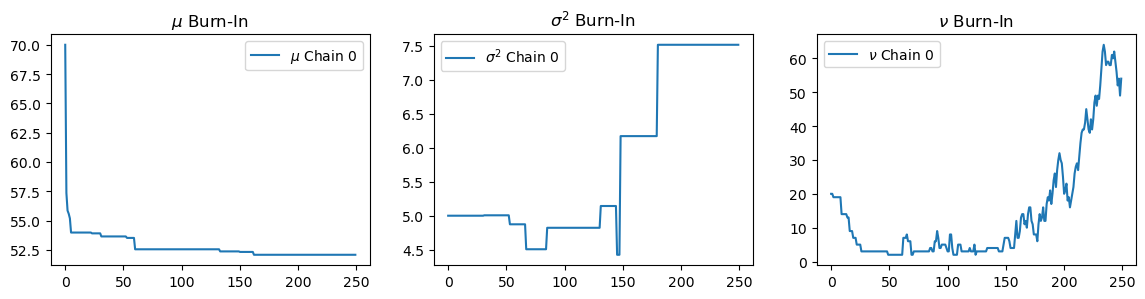

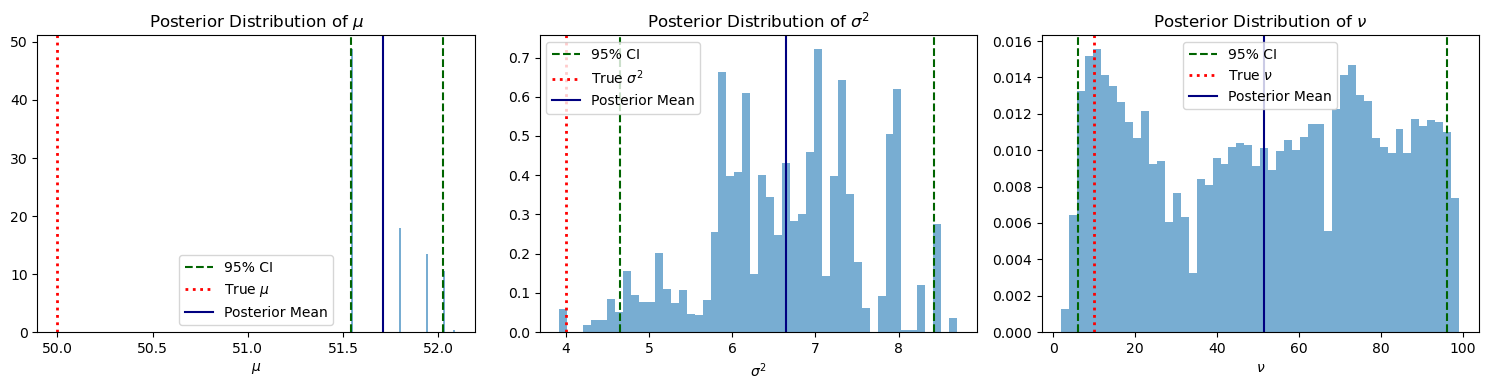

Metropolis-Within-Gibbs Bayesian Inference Results (n = 100):
True population mean ($\mu$): 50.00
95% Credible Interval for $\mu$: [51.54, 52.02]
Posterior mean for $\mu$: 51.71

True population variance ($\sigma^2$): 4.00
95% Credible Interval for $\sigma^2$: [4.65, 8.42]
Posterior mean for $\sigma^2$: 6.65

True population $\nu$: 10.00
95% Credible Interval for $\nu$: [6.00, 96.00]
Posterior mean for $\nu$: 51.42


In [8]:
# Burn-in phase
burn = 250
posterior_mu = mu_chain[0, burn:]
posterior_sigma2 = sigma2_chain[0, burn:]
posterior_nu = nu_chain[0, burn:]

# Plotting chains
fig, ax = plt.subplots(1, 3, figsize=(14, 3))
ax[0].set_title("$\\mu$ Burn-In")
ax[1].set_title("$\\sigma^2$ Burn-In")
ax[2].set_title("$\\nu$ Burn-In")
demo = 1000
for c in range(C):
    ax[0].plot(mu_chain[c, :burn], label="$\\mu$ Chain " + str(c))
    ax[1].plot(sigma2_chain[c, :burn], label="$\\sigma^2$ Chain " + str(c))
    ax[2].plot(nu_chain[c, :burn], label="$\\nu$ Chain " + str(c))
ax[0].legend(); ax[1].legend(); ax[2].legend();

# Compute credible intervals
mu_ci = np.quantile(posterior_mu, [0.025, 0.975])
sigma2_ci = np.quantile(posterior_sigma2, [0.025, 0.975])
nu_ci = np.quantile(posterior_nu, [0.025, 0.975])

# Plots of posterior distributions
fig, ax = plt.subplots(1, 3, figsize=(15, 4))

# -- Posterior of mu
ax[0].hist(posterior_mu, bins=50, density=True, alpha=0.6)
ax[0].axvline(mu_ci[0], color="darkgreen", linestyle="--", label="95% CI")
ax[0].axvline(mu_ci[1], color="darkgreen", linestyle="--")
ax[0].axvline(m_true, color="red", linestyle=":", linewidth=2, label="True $\\mu$")
ax[0].axvline(posterior_mu.mean(), color="navy", label="Posterior Mean")
ax[0].set_title("Posterior Distribution of $\\mu$")
ax[0].set_xlabel("$\\mu$")
ax[0].legend()

# -- Posterior of sigma^2
ax[1].hist(posterior_sigma2, bins=50, density=True, alpha=0.6)
ax[1].axvline(sigma2_ci[0], color="darkgreen", linestyle="--", label="95% CI")
ax[1].axvline(sigma2_ci[1], color="darkgreen", linestyle="--")
ax[1].axvline(sigma2_true, color="red", linestyle=":", linewidth=2, label="True $\\sigma^2$")
ax[1].axvline(posterior_sigma2.mean(), color="navy", label="Posterior Mean")
ax[1].set_title("Posterior Distribution of $\\sigma^2$")
ax[1].set_xlabel("$\\sigma^2$")
ax[1].legend()

# -- Posterior of nu
ax[2].hist(posterior_nu, bins=50, density=True, alpha=0.6)
ax[2].axvline(nu_ci[0], color="darkgreen", linestyle="--", label="95% CI")
ax[2].axvline(nu_ci[1], color="darkgreen", linestyle="--")
ax[2].axvline(v_true, color="red", linestyle=":", linewidth=2, label="True $\\nu$")
ax[2].axvline(posterior_nu.mean(), color="navy", label="Posterior Mean")
ax[2].set_title("Posterior Distribution of $\\nu$")
ax[2].set_xlabel("$\\nu$")
ax[2].legend()

plt.tight_layout()
plt.show()

# Print results
print(f"Metropolis-Within-Gibbs Bayesian Inference Results (n = {n}):")
print(f"====================================")
print(f"True population mean ($\\mu$): {m_true:.2f}")
print(f"95% Credible Interval for $\\mu$: [{mu_ci[0]:.2f}, {mu_ci[1]:.2f}]")
print(f"Posterior mean for $\\mu$: {posterior_mu.mean():.2f}")
print()
print(f"True population variance ($\\sigma^2$): {sigma2_true:.2f}")
print(f"95% Credible Interval for $\\sigma^2$: [{sigma2_ci[0]:.2f}, {sigma2_ci[1]:.2f}]")
print(f"Posterior mean for $\\sigma^2$: {posterior_sigma2.mean():.2f}")
print()
print(f"True population $\\nu$: {v_true:.2f}")
print(f"95% Credible Interval for $\\nu$: [{nu_ci[0]:.2f}, {nu_ci[1]:.2f}]")
print(f"Posterior mean for $\\nu$: {posterior_nu.mean():.2f}")

Even though I assigned very random values for the hyperparameters of each variable, the posterior estimates for $\mu$ and $\sigma^2$ seem reasonably close to their true values, 50 and 4, though they are not contained within the 95\% credible interval. However, the posterior estimate for $\nu$ is significantly different from its true value (10) and has a very wide credible interval, $[6.00, 96.00]$.

A likely reason for this behavior is the choice of the proposal distribution for $\nu$. Since we used a uniform symmetric random walk proposal, the newly proposed $\nu$ values are assigned equal probabilities across the entire range $[1,100]$. Because this proposal allows $\nu$ to explore a very wide range of values without favoring the true value, the resulting posterior distribution for $\nu$ is highly dispersed. 


### Q2: explore the role of sample size in providing inference for the degrees of freedom parameter $\nu$

*Implement the specification above using `PyMC` where you can explore inference on $\nu$ at different sample sizes. Provide a summarization and explanation of your findings.*

### Q2 Answer

In [1]:
import pymc as pm
import arviz as az

In [34]:
nu_proposal_sd = 2  # Small step size

with pm.Model() as t_norm_uni_discrete_local:
    
    # Priors
    theta = pm.Normal("theta", mu=mu_0, sigma=1/np.sqrt(tau_0))
    sigma2 = pm.HalfNormal("sigma2", sigma=np.sqrt(sigma2_0))
    
    # Discrete Uniform Prior
    nu = pm.DiscreteUniform("nu", lower=1, upper=100)

    # Likelihood
    x_observed = pm.StudentT("x_observed", nu=nu, mu=theta, sigma=np.sqrt(sigma2), observed=x)

    # Define a custom Metropolis step with a local move
    step = pm.Metropolis(vars=[nu], scaling=nu_proposal_sd)

    


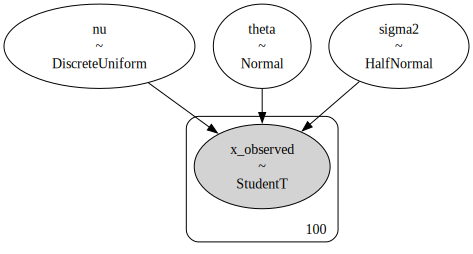

In [23]:
pm.model_to_graphviz(t_norm_uni)

In [36]:
m=10000
with t_norm_uni:
    idata = pm.sample(draws=m, chains=4, tune=1000)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [theta, sigma2]
>Metropolis: [nu]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 11 seconds.


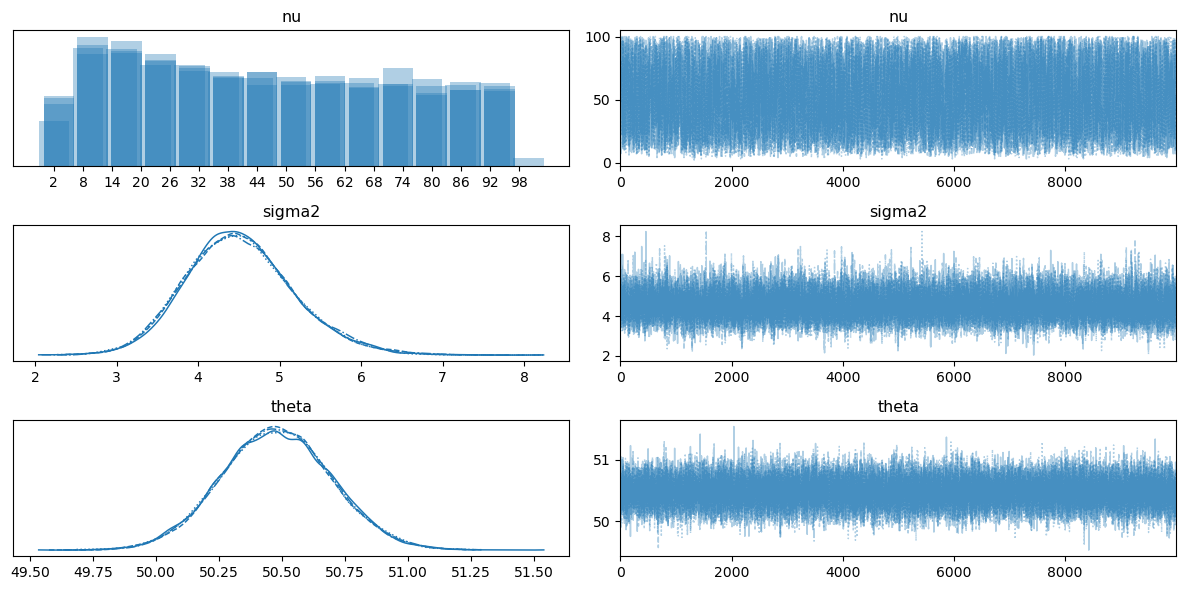

In [37]:
az.plot_trace(idata)
plt.tight_layout()

In [38]:
az.summary(idata, round_to=5, hdi_prob=0.95)

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
nu,49.11180,27.74969,5.00000,95.00000,0.34782,0.24595,5718.14606,6019.13580,1.00038
sigma2,4.50990,0.66798,3.24860,5.86363,0.00478,0.00338,18828.24693,17408.45393,1.00034
theta,50.47869,0.21761,50.05046,50.90234,0.00115,0.00081,35799.71942,28591.98250,1.00007


Again, the mean values for $\sigma^2$ (4.5) and $\theta$ (which is $\mu$) (50.48) show very close value to their true values, 4 and 50. Also, the 95% HDI for $\sigma^2$ contains its true value, and it shows the algorithm was applied adequetely. Additionally, their Markov Chain Standard Errors show very small values which suggest that it is esimated correctly and certainly.(Also the chain movement for $\sigma^2$ fluctuates across the true value 5, and chain movement for $\theta$ fluctuates across 50.5(possibly due to the poor assignment of hyperparameters))
However,for $\nu$, it shows very weird value as 49.112 which is much larger than the true value, 10. Even with the special assignment for the local movement of $\nu$ (as Metropolis Hasting with step size = 2), it shows very wide range of exploration since the proposal distribution is uniform, and the 95% HDI (of course) looks very wide. (and also the MCSE is very large) 

### Q3: the posterior predictive distribution does something like the following...

Let $p(\tau_i)$ be $\require{cancel} \textrm{gamma}\big(\tau_i | \alpha = \frac{\nu}{2}, \overset{\textrm{rate}\xcancel{\textrm{scale}}}{\beta = \frac{\nu}{2}}\big)$ and let $p(y_i|\tau_i)$ be $\textrm{N}(y_i | 0,\tau_i)$ and now integrate out the uncertainty in $\tau_i$ and see what distribution is left over for $y_i$.

*Go look at the gamma distribution and remember that you know that the integrals of unnormalized densities are the inverse of their normalizing constants. Then go look at the t distribution and determine what distribution the following expression defines. Then explain why the behavior demonstrated here is analagous to that of the posterior predictive distribution.*

$$\int p(y_i|\tau_i) p(\tau_i)  d\tau_i = \int \sqrt{\frac{\tau_i}{2\pi}}e^{-\frac{1}{2}\tau_i y_i^2} \frac {\frac{\nu}{2}^{\frac{\nu}{2}}}{\Gamma \left(\frac{\nu}{2}\right)} \tau_i^{\frac{\nu}{2}-1}e^{-\frac{\nu}{2}\tau_i} d\tau_i$$

### Q3 Answer

## **Step 1: Given Distributions**
We have:

1. **Prior for** $\tau_i$ (Gamma distribution):
   $$
   p(\tau_i) = \text{Gamma} \left( \tau_i \mid \alpha = \frac{\nu}{2}, \beta = \frac{\nu}{2} \right)
   $$
   - Shape parameter: $\alpha = \frac{\nu}{2}$
   - Rate parameter: $\beta = \frac{\nu}{2}$

2. **Likelihood** $p(y_i | \tau_i$ (Normal distribution):
   $$
   p(y_i | \tau_i) = \sqrt{\frac{\tau_i}{2\pi}} e^{-\frac{1}{2} \tau_i y_i^2}
   $$
   where $\tau_i$ is the precision (inverse variance).

We want to integrate out $\tau_i$:

$$
p(y_i) = \int p(y_i | \tau_i) p(\tau_i) \, d\tau_i
$$

which corresponds to the integral:

$$
\int \sqrt{\frac{\tau_i}{2\pi}}e^{-\frac{1}{2}\tau_i y_i^2} \frac{\left(\frac{\nu}{2}\right)^{\frac{\nu}{2}}}{\Gamma \left(\frac{\nu}{2}\right)} \tau_i^{\frac{\nu}{2}-1}e^{-\frac{\nu}{2}\tau_i} d\tau_i.
$$

---

## **Step 2: Recognizing the Integral Structure**
Rearranging the terms inside the integral:

$$
p(y_i) = \frac{\left(\frac{\nu}{2}\right)^{\frac{\nu}{2}}}{\Gamma \left(\frac{\nu}{2}\right)} \sqrt{\frac{1}{2\pi}}
\int \tau_i^{\frac{\nu}{2} - \frac{1}{2}} e^{-\left(\frac{1}{2} y_i^2 + \frac{\nu}{2} \right) \tau_i} d\tau_i.
$$

This integral has the form:

$$
\int x^{a-1} e^{-bx} dx = \frac{\Gamma(a)}{b^a}, \quad \text{for } a > 0, b > 0.
$$

Comparing:

- $a = \frac{\nu}{2} + \frac{1}{2} = \frac{\nu + 1}{2}$
- $b = \frac{1}{2} y_i^2 + \frac{\nu}{2} = \frac{\nu + y_i^2}{2}$

Applying the gamma integral result:

$$
\int \tau_i^{\frac{\nu}{2} - \frac{1}{2}} e^{-\left(\frac{1}{2} y_i^2 + \frac{\nu}{2} \right) \tau_i} d\tau_i
= \frac{\Gamma \left(\frac{\nu+1}{2} \right)}{\left( \frac{\nu + y_i^2}{2} \right)^{\frac{\nu+1}{2}}}.
$$

---

## **Step 3: Simplifying the Expression**
$$
p(y_i) = \frac{\left(\frac{\nu}{2}\right)^{\frac{\nu}{2}}}{\Gamma \left(\frac{\nu}{2}\right)} \sqrt{\frac{1}{2\pi}}
\frac{\Gamma \left(\frac{\nu+1}{2} \right)}{\left( \frac{\nu + y_i^2}{2} \right)^{\frac{\nu+1}{2}}}.
$$

Using the **Gamma function identity**:

$$
\frac{\Gamma\left(\frac{\nu+1}{2}\right)}{\Gamma\left(\frac{\nu}{2}\right)}
= \frac{\sqrt{\pi}}{(\nu/2)^{1/2}}.
$$

we substitute this into the equation:

$$
p(y_i) = \frac{\Gamma\left(\frac{\nu+1}{2}\right)}{\sqrt{\pi \nu} \Gamma\left(\frac{\nu}{2}\right)}
\left(1 + \frac{y_i^2}{\nu} \right)^{-\frac{\nu+1}{2}}.
$$

which matches the **Student’s \( t \)-distribution**:

$$
y_i \sim t_{\nu}(0,1).
$$

---

## **Step 4: Connection to the Posterior Predictive Distribution**
- In **Bayesian inference**, we often marginalize out unknown parameters to account for uncertainty.
- Here, we marginalized out $\tau_i$ (precision) to obtain the **marginal distribution of $y_i$**.
- The resulting **Student’s $t$-distribution** has heavier tails than a normal distribution.
- This behavior is **analogous to the posterior predictive distribution**, which accounts for parameter uncertainty rather than using a fixed estimate.

---

## **Conclusion**
1. **We showed that integrating out $\tau_i$ leads to a Student’s $t$-distribution for $y_i$.**  
2. **This is analogous to posterior predictive inference, where we integrate over parameter uncertainty instead of plugging in a fixed estimate.**  


